# Name: Sumer Malhotra (3035347457)

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import scorecardpy as sc
from pygam import LogisticGAM,f,s
import warnings
warnings.filterwarnings("ignore")

## Reading datasheets

In [4]:
df1 = pd.read_csv('HelocData.csv')
df2 = pd.read_excel('HelocDataDict.xlsx')
riskFlag = df1['RiskFlag']

## Feature Selection and Imputation

In [5]:
df1 = df1[['x1', 'x5', 'x16', 'x17', 'x20']]
df1 = df1.replace([-7, -8, -9], np.nan)
print(df1.columns)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df1 = imputer.fit_transform(df1)
df1 = pd.DataFrame(df1)
df1['RiskFlag'] = riskFlag
df1.columns = ['x1', 'x5', 'x16', 'x17', 'x20', 'RiskFlag']
df1['RiskFlag'] = df1['RiskFlag'].replace('Good', 1)
df1['RiskFlag'] = df1['RiskFlag'].replace('Bad', 0)
df_cp = df1.copy()

Index(['x1', 'x5', 'x16', 'x17', 'x20'], dtype='object')


## Q1) IV Binning

In [6]:
x1bins = sc.woebin(df1,y='RiskFlag',x='x1')

x1breaks = x1bins['x1']['breaks'].values.astype(np.float)
x1breaks_ = np.insert(x1breaks,0,-np.inf)
x1bins['x1']['breaks'] = x1breaks.round(3).astype(str)
x1bins['x1']['bin'] = pd.cut(x1breaks_[:-1],x1breaks_,right=False)
df1['x1'] = pd.cut(df1['x1'],x1breaks_,right=False)

x5bins = sc.woebin(df1, y='RiskFlag', x='x5')
x5breaks = x5bins['x5']['breaks'].values.astype(np.float)
x5breaks_ = np.insert(x5breaks,0,-np.inf)
x5bins['x5']['breaks'] = x5breaks.round(3).astype(str)
x5bins['x5']['bin'] = pd.cut(x5breaks_[:-1],x5breaks_,right=False)
df1['x5'] = pd.cut(df1['x5'],x5breaks_,right=False)

x16bins = sc.woebin(df1,y='RiskFlag',x='x16')
x16breaks = x16bins['x16']['breaks'].values.astype(np.float)
x16breaks_ = np.insert(x16breaks,0,-np.inf)
x16bins['x16']['breaks'] = x16breaks.round(3).astype(str)
x16bins['x16']['bin'] = pd.cut(x16breaks_[:-1],x16breaks_,right=False)
df1['x16'] = pd.cut(df1['x16'],x16breaks_,right=False)

x17bins = sc.woebin(df1,y='RiskFlag',x='x17')
x17bins['x17']
x17breaks = x17bins['x17']['breaks'].values.astype(np.float)
x17breaks_ = np.insert(x17breaks,0,-np.inf)
x17bins['x17']['breaks'] = x17breaks.round(3).astype(str)
x17bins['x17']['bin'] = pd.cut(x17breaks_[:-1],x17breaks_,right=False)
df1['x17'] = pd.cut(df1['x17'],x17breaks_,right=False)

x20bins = sc.woebin(df1,y='RiskFlag',x='x20')
x20breaks = x20bins['x20']['breaks'].values.astype(np.float)
x20breaks_ = np.insert(x20breaks,0,-np.inf)
x20bins['x20']['breaks'] = x20breaks.round(3).astype(str)
x20bins['x20']['bin'] = pd.cut(x20breaks_[:-1],x20breaks_,right=False)
df1['x20'] = pd.cut(df1['x20'],x20breaks_,right=False)

[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...


 ## Label Encoding

In [7]:
LE = LabelEncoder()
for col in ['x1','x5','x16','x17','x20']:
    df1[col] = LE.fit_transform(df1[col])

## Splitting data into Train and Test

##### Training and testing data with binning



In [8]:
np.random.seed(3035347457)
df_train,df_test = train_test_split(df1,test_size=0.2)
X_train = df_train.iloc[:, 0:-1].values
y_train = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, 0:-1].values
y_test = df_test.iloc[:, -1].values

##### Training and testing data without binning



In [9]:
df_train_2,df_test_2 = train_test_split(df_cp,test_size=0.2)
X_train_2 = df_train_2.iloc[:, 0:-1].values
y_train_2 = df_train_2.iloc[:, -1].values
X_test_2 = df_test_2.iloc[:, 0:-1].values
y_test_2 = df_test_2.iloc[:, -1].values

## Q1) Training the GAM Model

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


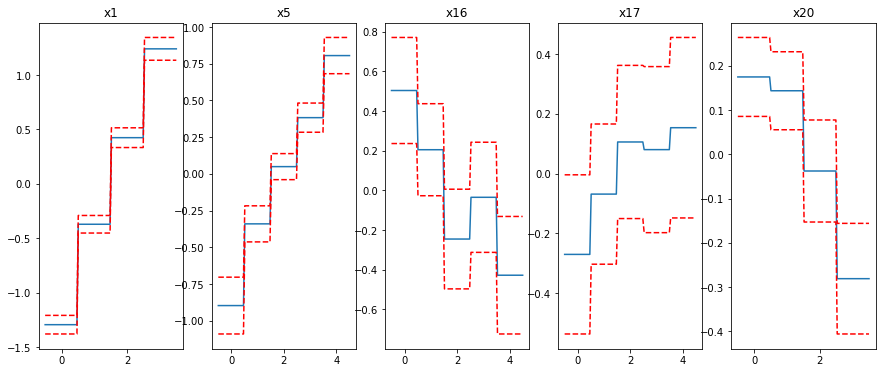

In [10]:
gam = LogisticGAM(f(0)+f(1)+f(2)+f(3)+f(4))
gam.gridsearch(X_train,y_train)

fig, axes = plt.subplots(1, 5,figsize=(15,6))
titles = ['x1','x5','x16','x17','x20']

for i, ax in enumerate(axes):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    plt.subplot(axes[i])
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(titles[i])

## Accuracy of GAM + Binning

In [11]:
y_pred_train = gam.predict(X_train)
y_pred_test = gam.predict(X_test)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test))

The Acc on training set: 0.7132783554440062
The Acc on testing set: 0.6988527724665392


## Q2) Piecewise Linear Feature Engineering

In [12]:
gam2 = LogisticGAM(s(0,n_splines=20,spline_order=1)+s(1,n_splines=20, spline_order=1)
                   +s(2,n_splines=20, spline_order=1)+s(3,n_splines=20, spline_order=1)
                   +s(4,n_splines=20, spline_order=1))

##### Model Accuracy on binned data

In [13]:
gam2.gridsearch(X_train,y_train)
y_pred_train = gam2.predict(X_train)
y_pred_test = gam2.predict(X_test)
print('The Acc on training set:',accuracy_score(y_train,y_pred_train))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


The Acc on training set: 0.7124417353890283
The Acc on testing set: 0.6993307839388145


##### Model Accuracy on unbinned data

In [14]:
gam2.gridsearch(X_train_2,y_train_2)
y_pred_train = gam2.predict(X_train_2)
y_pred_test = gam2.predict(X_test_2)
print('The Acc on training set:',accuracy_score(y_train_2,y_pred_train))
print('The Acc on testing set:',accuracy_score(y_test_2,y_pred_test))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


The Acc on training set: 0.7123222182383172
The Acc on testing set: 0.7151051625239006


## Q3) Penalized B-Spline + Accuracy

##### Model Accuracy on binned data

In [15]:
spline_orders = [2,3]
for order in spline_orders:
    p_spl = LogisticGAM(s(0,n_splines=20, penalties='derivative', spline_order=order)
                        +s(1,n_splines=20,penalties='derivative', spline_order=order)
                        +s(2,n_splines=20, penalties='derivative', spline_order=order)
                        +s(3,n_splines=20,penalties='derivative', spline_order=order)
                        +s(4,n_splines=20, penalties='derivative', spline_order=order))
    p_spl.gridsearch(X_train, y_train)

    y_pred_train3 = p_spl.predict(X_train)
    y_pred_test3 = p_spl.predict(X_test)

    print('The Acc on training set:',accuracy_score(y_train,y_pred_train3))
    print('The Acc on testing set:',accuracy_score(y_test,y_pred_test3))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7124417353890283
The Acc on testing set: 0.6993307839388145


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


The Acc on training set: 0.7124417353890283
The Acc on testing set: 0.6993307839388145


##### Model Accuracy on unbinned data

In [17]:
spline_orders = [i for i in range(1,11)]
for order in spline_orders:
    p_spl = LogisticGAM(s(0,n_splines=20, penalties='derivative', spline_order=order)
                        +s(1,n_splines=20,penalties='derivative', spline_order=order)
                        +s(2,n_splines=20, penalties='derivative', spline_order=order)
                        +s(3,n_splines=20,penalties='derivative', spline_order=order)
                        +s(4,n_splines=20, penalties='derivative', spline_order=order))
    p_spl.gridsearch(X_train_2, y_train_2) 

    y_pred_train3 = p_spl.predict(X_train_2)
    y_pred_test3 = p_spl.predict(X_test_2)

    print('The Acc on training set:',accuracy_score(y_train_2,y_pred_train3))
    print('The Acc on testing set:',accuracy_score(y_test_2,y_pred_test3))

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7129198039918728
The Acc on testing set: 0.7122370936902486


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7129198039918728
The Acc on testing set: 0.7127151051625239


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7129198039918728
The Acc on testing set: 0.7131931166347992


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7126807696904506
The Acc on testing set: 0.7136711281070746


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7128002868411617
The Acc on testing set: 0.7141491395793499


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7135173897454284
The Acc on testing set: 0.7136711281070746


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7129198039918728
The Acc on testing set: 0.7146271510516252


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7128002868411617
The Acc on testing set: 0.7155831739961759


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

The Acc on training set: 0.7129198039918728
The Acc on testing set: 0.7146271510516252


100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


The Acc on training set: 0.7133978725947173
The Acc on testing set: 0.7146271510516252


## Q4)  Model Evaluation

### Models used
1. Generalized Additive Model with Binning
2. Generalized Additive Model with Piecewise Linear Feature Engineering
3. Generalized Additive Model with Penalized B-Splines

### Evaluation Criteria
1. Model Explainability 
2. Model Accuracy

I will only consider the accuracy on the testing data. For 2 and 3, the model has been fitted on both binned and unbinned data. For these cases, I will consider the model with higher testing accuracy. For 3, the model has been tested with spline orders of 1, 2 and 3. Again, I will consider the model with the highest testing accuracy. 

### Results and Recommendation
The accuracy for the following models is as follows:
1. Generalized Additive Model with Binning (69.89%)
2. Generalized Additive Model with Piecewise Linear Feature Engineering (71.51%)
3. Generalized Additive Model with Penalized B-Splines (71.32%)

In terms of Model accuracy, GAM with Piecewise Linear Feature Engineering is the highest. The difference in accuracies between the models however, don't appear to be significant and can be attributed to statistical error.

In terms of interpretability, I would assess that the models are fairly equivalent. In terms of accuracy, it is intuitive that classifying categorical variables as categorical and continuous variables as continous (i.e. using s(.) and f(.) appropriately) is sure to increase accuracy. Due to time constraints involved with the working of python libraries like pygam, scorecardpy and progressbar on the latest installation of mac OS, I had difficulty in comprehensively testing more combinations. 

- For the binning algo, there are multiple techniques that can be applied like equal width and frequency binning. Furthermore, there is support for binning through various python packages like pandas, sci-kit learn and scorecardpy. Testing of all these algos on the model may affect the final accuracy of the first model. After the binning step, encoding is done and can be done in different ways. For the purpose of this assignment, LabelEncoder() is used, however OneHotEncoder() may give more promising results. 

- For Linear GAM, increasing/decreasing the number of splines may increase model accuracy.

- For B-Splines GAM, increasing/decreasing the number of splines may increase model accuracy as well. Furthermore, modifcation and optimization of spline order will increase accuracy (In extreme cases this could lead to over/under fitting). Other things that could contribute to model accuracy for this is using s(.) and f(.) optimally for the variables. Correct usage of these pygam packages could significantly increase accuracy.

In terms of explainability, I can conclude that the binning technique is more understandable than the other 2. However, the most significant differnece in accuracy can be seen between binning and linear GAM and b-splines GAM. Therefore, I conclude that linear GAM/b-splines is the best model and should be applied for this problem after further investigating the causal effects between the features and the response. The mathematics involved is complex and not immediately understandable but certain inferences can be taken by looking at the performance of the model for different parameters which makes model-tuning possible. 

### Extra Inferences

An interesting observation for the Generalized Additive Model with Penalized B-Splines is that, on increasing the spline order, the accuracy gradually increases up until degree 5, after which it stabilizes at around 71.5%. [I tested degrees 1-10]